# Análisis de las ventas de cerveza en una cadena de supermercados

### Descripción del problema

El objetivo de este reto es analizar las ventas de cerveza para una cadena de supermercados. Para ello, tenemos una muestra de las ventas a nivel de tique registrados durante un mes y un agregado de ventas a nivel día durante varios años.


### Información de partida

Los ficheros disponibles para este análisis son los siguientes:

* `beer_master.csv`: contiene la información del maestro de productos. Tiene los siguientes campos:
 * `Articulo_Codigo`: identificador numérico del producto.
 * `Articulo_Nombre`: nombre descriptivo del producto.
 * `Grupo_Código`: identificador numérico de la categoría a la que pertenece el producto. En este caso es constante pues solo vamos a analizar cervezas.
 * `Grupo_Nombre`: nombre descriptivo de la categoría a la que pertenece el producto. Solo hay uno: CERVEZAS.
 * `Subgrupo_Codigo`: identificador numérico de la subcategoría a la que pertenece el producto.
 * `Subgrupo_Nombre`: nombre descriptivo de la subcategoría a la que pertenece el producto.


* `beer_sales.h5`: para un mes de extracción, contiene todos los tickets de venta de cervezas (a nivel de línea de ticket). Tiene los siguientes campos:
 * `articulo`: identificador único del artículo comprado
 * `cantidad`: unidades compradas de ese artículo en el ticket
 * `importe`: importe en euros de ese artículo en el ticket
 * `tienda`: identificador único de la tienda donde se produjo la linea de ticket
 * `caja`: identificador de la caja registradora en la que se produjo la linea de ticket
 * `dia`: dia en el que se produjo la linea de ticket
 * `hora`: hora en la que se produjo la linea de ticket
 * `minuto`: minuto en el que se produjo la linea de ticket
 * `ticket`: identificador NO único del ticket (es un identificador del ticket por tienda y caja)


* `beer_sales_byday.h5`: contiene las ventas agregadas a día por producto y tienda. Tiene los siguientes campos:
 * `categoria`: nombre descriptivo de la categoría a la que pertenece el producto. Solo hay uno: CERVEZAS.
 * `anio`, `mes`, `dia`: año, mes y día para la venta agregada.
 * `tienda`: identificador único para la tienda en la que se realizan las ventas.
 * `articulo`: identificador único del artículo comprado.
 * `cantidad`: unidades vendidas.

### Desarrollo de la solución -- Análisis a línea de tiques

Vamos a comenzar nuestro análisis sobre el extracto de ventas a nivel de líneas de tiques (fichero beer_sales.h5) para establecer el correcto preprocesado que deberíamos realizar para poder tener nuestras ventas agregadas correctamente.

**1) Como se ha comentado en la información de partida, el campo ticket del dataset de ventas no es único. Es decir, puede haber líneas de ticket que compartan valor de ticket sin pertenecer necesariamente al mismo ticket. Dada la información disponible, ¿se te ocurre alguna manera de generar un id de ticket que identifique unequívocamente las lineas que pertenecen a un mismo ticket?**

In [1]:
import pandas as pd
import numpy as np

sales_df = pd.read_hdf('beer_sales.h5', 's')
master_df = pd.read_csv('beer_master.csv')
sales_byday_df = pd.read_hdf('beer_sales_byday.h5', 'df_sales')

sales_df.head()

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda
0,19519,3,1.0,23,13,6.12,19,137,14808
1,19519,3,1.0,29,11,6.12,52,78,14808
2,7571,2,6.0,30,18,3.90,37,310,14967
3,8128,3,1.0,5,13,0.00,44,57,14214
4,13340,3,1.0,5,13,0.00,44,57,14214


In [2]:
# Solución 1: Concatenar las 3 columnas
    # Añadiendo un separador para evitar que dos tickets distintos generen el mismo ticket_id
        # 12 3 1 = 1231 -> 12-3-1
        # 1 23 1 = 1231 -> 1-23-1

sales_df['ticket_id'] = sales_df['tienda'].astype(str) + '-' + sales_df['caja'].astype(str) + '-' + sales_df['ticket'].astype(str)

# Solución 2: Crear un hash de las 3 columnas
import hashlib

def generate_hash(row):
    return hashlib.sha256(str(row['ticket_id']).encode()).hexdigest()
sales_df['ticket_hash'] = sales_df.apply(generate_hash, axis=1)

**2) ¿Se te ocurre alguna manera de verificar que el identificador generado agrupa correctamente las líneas de ticket? ¿Qué consecuencias crees que podría tener el no generarlo correctamente?**

In [3]:
# Verficar el valor único de cada ticket_id y ticket.

print("Total de lineas: " + str(sales_df.shape[0]))
print("Valores únicos de ticket_id: " + str(sales_df['ticket_id'].nunique()))
print("Valores únicos de ticket: " + str(sales_df['ticket'].nunique()))

Total de lineas: 45835
Valores únicos de ticket_id: 37310
Valores únicos de ticket: 610


In [4]:
# Revisando el dataset se puede observar que se da lo siguiente:

# 1. Existen diferentes lineas de venta del mismo artículo para el mismo ticket_id (único, al ser la combinación del ticket, caja y tienda)
print("Valores únicos de articulo por ticket_id: " + str(sales_df.groupby('ticket_id')['articulo'].value_counts()))

# 2. Existen diferentes lineas de venta de fecha distinta para el mismo ticket_id (mismo ticket, caja y tienda)
# Ticket = x, Caja = y, Tienda = z
    # articulo A = 13/09/2021
    # articulo B = 23/09/2021

print("\nValores únicos de 'dia': " + str(sales_df.groupby('ticket_id')['dia'].value_counts()))
print("\nValores únicos de 'dia': " + str(sales_df.groupby('ticket_id')['hora'].value_counts()))


Valores únicos de articulo por ticket_id: ticket_id    articulo
14018-2-1    10486       2
             11213       1
14018-2-10   10486       1
14018-2-103  10486       2
14018-2-108  10486       1
                        ..
14982-1-8    8128        1
             11213       1
             12814       1
14982-1-9    11213       1
             15087       1
Name: count, Length: 44600, dtype: int64

Valores únicos de 'dia': ticket_id    dia
14018-2-1    9      2
             12     1
14018-2-10   9      1
14018-2-103  1      1
             14     1
                   ..
14982-1-8    19     1
             29     1
             5      1
14982-1-9    4      1
             6      1
Name: count, Length: 43534, dtype: int64

Valores únicos de 'dia': ticket_id    hora
14018-2-1    8       2
             9       1
14018-2-10   9       1
14018-2-103  12      1
             11      1
                    ..
14982-1-5    9       4
14982-1-6    9       2
14982-1-8    9       2
             11      

In [5]:
# En este ejemplo podemos ver que en un mismo ticket hay lineas de venta con fecha distinta, lo que no tiene sentido.

sales_df[sales_df['ticket_id'] == '14018-2-1']

,articulo,caja,cantidad,dia,hora,importe,minuto,ticket,tienda,ticket_id,ticket_hash
183,10486,2,2.0,9,8,1.00,8,1,14018,14018-2-1,4b80cc9108b8ad83c917986960d728834616eab002731c...
184,11213,2,1.0,9,8,0.52,8,1,14018,14018-2-1,4b80cc9108b8ad83c917986960d728834616eab002731c...
3816,10486,2,2.0,12,9,1.00,3,1,14018,14018-2-1,4b80cc9108b8ad83c917986960d728834616eab002731c...


In [6]:
# La verficación muestra que el ticket_id no es único por fila en el conjunto de datos, 
# lo cual es esperado y correcto en este contexto, ya que cada fila corresponde a un producto, y un ticket puede tener varios productos.

# Sin embargo, hay casos en los que las distintas lineas de venta de un mismo ticket tienen fecha distinta y / o productos repetidos. 
# Para verificar el ticket_id generado, sería necesario tener más información sobre la lógica de negocio detrás de la generación de los tickets.

# No generar el ticket_id correctamente podría resultar en una agregación incorrecta de las ventas, 
# afectando así en el posterior análisis como al determinar el volumen de ventas por ticket, y la identificación de patrones de compra entre otros.

**3) Se han detectado una serie de tickets anómalos en los que la cantidad de cervezas compradas es extremadamente alto. ¿Cómo harías para detectarlos y filtrarlos de nuestro conjunto de ventas?**

count    37310.000000
mean         6.345403
std         14.666237
min         -7.000000
25%          2.000000
50%          5.000000
75%          8.000000
max       1596.000000
Name: cantidad, dtype: float64


<Axes: xlabel='cantidad'>

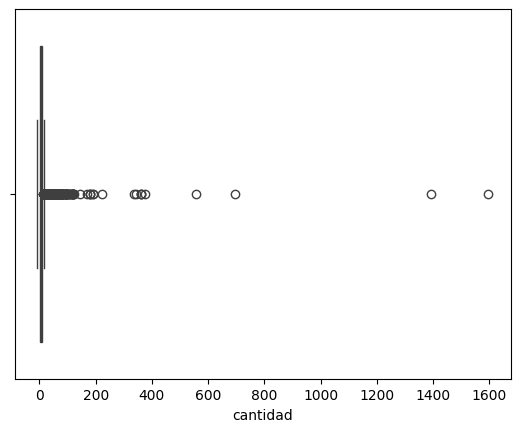

In [7]:
# Visualizar la distribución del número de cervezas vendidas por ticket

import seaborn as sns
import matplotlib.pyplot as plt

sales_byticket = sales_df.groupby('ticket_id')['cantidad'].sum()

print(sales_byticket.describe())
sns.boxplot(x=sales_byticket)

In [8]:
# Solución: Identificar outliers por cuantiles
# En este caso usaremos el cuantil 0.99995 para identificar los outliers, dada la distribución de los datos.

limit = sales_byticket.quantile(0.99995) 
print("Límite: " + str(limit))
outliers = sales_byticket[sales_byticket > limit]
print(outliers)

# Para filtrar y actualizar el dataset podemos extraer el ticket_id de los outliers y filtrar el dataset original.
clean_sales_df = sales_df[~sales_df['ticket_id'].isin(outliers.index)]

Límite: 788.7813500017364
ticket_id
14056-2-37    1392.0
14212-5-1     1596.0
Name: cantidad, dtype: float64


In [9]:
# También podemos detectar outliers con algoritmos como Local Outlier Factor (LOF) o Isolation Forest. 

**4) ¿Se te ocurre alguna manera de automáticamente detectar estos tickets en el futuro? ¿Y algún motivo de su presencia?**

In [10]:
# Integrando la comprobación de tickets anómalos en el proceso de transformación de la ETL. 
# Además de enviar una notificación (logs) cuando se detecte un ticket anómalo.

# Su presencia se puede dar por un error en el proceso de ETL, por un error en el sistema de punto de venta o por algún error humano.

**5) A continuación, nos gustaría analizar qué cervezas se compran juntas más a menudo. Para ello, a partir de los tickets, calcula el número de veces que se compran cada par de articulos conjuntamente (en el mismo ticket).**

In [11]:
# Para analizar qué cervezas se compran juntas más a menudo podemos usar el algoritmo de reglas de asociación Apriori.

In [12]:
from mlxtend.frequent_patterns import apriori

# Crear un dataframe con los ticket_id y la cantidad por artículo
basket = (clean_sales_df
          .groupby(['ticket_id', 'articulo'])['cantidad']
          .sum().unstack().reset_index().fillna(0)
          .set_index('ticket_id'))

# Convertir la cantidad a 0 o 1 (existe / no existe)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)
frequent_itemsets = apriori(basket_sets, min_support=0.003, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] == 2]
# 'support' hace referencia a la frecuencia con la que aparece el conjunto de artículos en los tickets
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
print(frequent_itemsets)

/var/folders/zp/9kkn3ltx55q4wz7hp7q19ggm0000gn/T/ipykernel_99734/841817700.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)
/Users/carlosfiestas/Documents/Challenge_DA/.venv/lib/python3.9/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


     support        itemsets  length
35  0.010668   (8128, 11213)       2
37  0.010507   (8128, 13340)       2
33  0.007317   (7643, 11213)       2
39  0.006353  (11213, 10486)       2
41  0.005468  (13340, 11213)       2
30  0.005227   (7571, 11213)       2
32  0.005146   (7643, 10486)       2
31  0.004476    (8128, 7643)       2
42  0.004208  (11213, 18495)       2
29  0.003994    (8128, 7571)       2
36  0.003726   (8128, 12814)       2
34  0.003350   (8128, 10486)       2
38  0.003270   (8128, 14907)       2
40  0.003136  (11213, 12814)       2
43  0.003082  (11213, 19519)       2


### Desarrollo de la solución -- Análisis agregado de ventas

Supongamos que tras realizar el preprocesado de la información, conseguimos un dataset agregado de las ventas de las cervezas por día, tienda y producto (fichero beer_sales_byday.h5)

**1) Enriquece el dataset de las ventas agregadas por día con los nombres y subcategorías de las cervezas.**

In [13]:
sales_byday_df.head()

,categoria,anio,mes,dia,tienda,articulo,cantidad
0,CERVEZAS,2021,9,28,14059,12109,5.0
1,CERVEZAS,2021,9,28,14059,12656,1.0
2,CERVEZAS,2021,9,28,14059,13305,8.0
3,CERVEZAS,2021,9,28,14059,13717,1.0
4,CERVEZAS,2021,9,28,14059,16387,1.0


In [14]:
master_df.drop_duplicates(inplace=True)
master_df.reset_index(inplace=True)

In [15]:
master_df['Articulo_Codigo'] = master_df['Articulo_Codigo'].astype(str)
sales_byday_df['articulo'] = sales_byday_df['articulo'].astype(str)
sales_byday_df = sales_byday_df.merge(master_df[['Articulo_Codigo', 'Articulo_Nombre']], left_on='articulo', right_on='Articulo_Codigo', how='left')
sales_byday_df.head()

,categoria,anio,mes,dia,tienda,articulo,cantidad,Articulo_Codigo,Articulo_Nombre
0,CERVEZAS,2021,9,28,14059,12109,5.0,12109,CERVEZA DESPERADOS BT.33CL
1,CERVEZAS,2021,9,28,14059,12656,1.0,12656,CERVEZA NEGRA MODELO BT.35CL
2,CERVEZAS,2021,9,28,14059,13305,8.0,13305,CERVEZA LA SAGRA INDIAN IPA BT33CL
3,CERVEZAS,2021,9,28,14059,13717,1.0,13717,CERVEZA STELLA ARTOIS BT.33 CL
4,CERVEZAS,2021,9,28,14059,16387,1.0,16387,CERVEZA GAR&GAR URUMEA 1/3


**2) ¿Cuál es el top 10 de cervezas más vendidas en esta cadena de supermercados? Representa el resultado a través de una gráfica.**

<Axes: title={'center': 'Top 10 cervezas vendidas'}, ylabel='Cantidad vendida'>

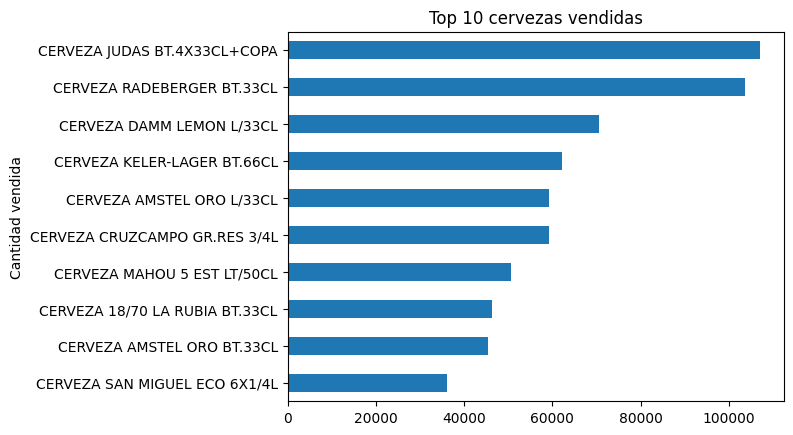

In [16]:
# Visualizar el top 10 de cervezas vendidas
top10 = sales_byday_df.groupby('Articulo_Nombre')['cantidad'].sum().nlargest(10).sort_values()
top10.plot(kind='barh', title='Top 10 cervezas vendidas', ylabel='Cantidad vendida')

**3) ¿Qué cerveza ha crecido más en ventas en los últimos 6 meses con respecto a los 6 meses anteriores?**

In [21]:
# Crear nueva columna con la fecha completa, y convertir a datetime dd/mm/yyyy
sales_byday_df['fecha'] = sales_byday_df['anio'].astype(str) + '-' + sales_byday_df['mes'].astype(str) + '-' + sales_byday_df['dia'].astype(str)
sales_byday_df['fecha'] = pd.to_datetime(sales_byday_df['fecha'], format='%Y-%m-%d')

In [22]:
six_months_ago = sales_byday_df['fecha'].max() - pd.DateOffset(months=6)

previous_df = sales_byday_df[sales_byday_df['fecha'] < six_months_ago]
recent_df = sales_byday_df[sales_byday_df['fecha'] >= six_months_ago]

recent_sales = recent_df.groupby('Articulo_Nombre')['cantidad'].sum()
previous_sales = previous_df.groupby('Articulo_Nombre')['cantidad'].sum()

abs_growth = recent_sales - previous_sales
rel_growth = (recent_sales - previous_sales) / previous_sales

max_growth_beer = abs_growth.idxmax()

print("Cerveza con mayor crecimiento absoluto: " + max_growth_beer)

Cerveza con mayor crecimiento absoluto: CERVEZA COLEGIATA RADLER B33CL


**EXTRA: 4) Queremos catalogar los supermercados en función de sus ventas, de forma que los de tipo A son aquellos que realizan el 20% total de las ventas; los de tipo B, el 50% y los de tipo C, el resto.
Tras realizar esta categoría, ¿cómo evolucionan las ventas a nivel diario para los supermercados tipo A?**

<function matplotlib.pyplot.show(close=None, block=None)>

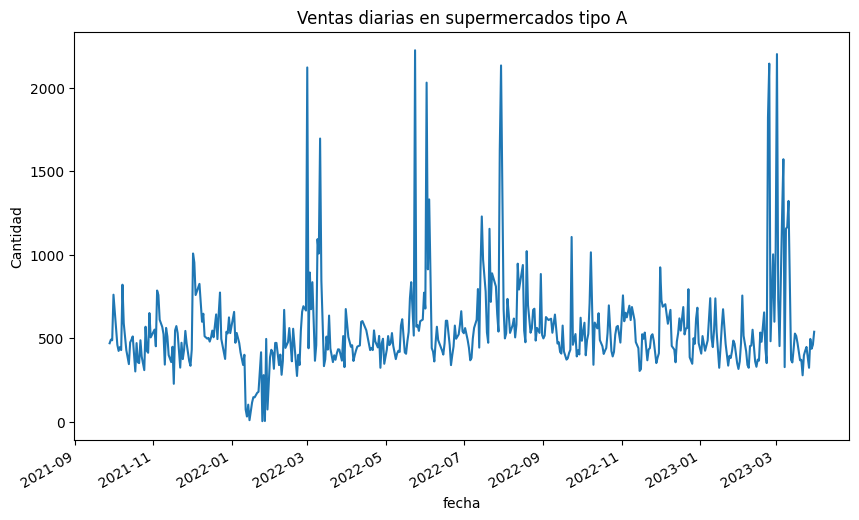

In [27]:
# Calcular ventas totales por supermercado
total_sales = sales_byday_df.groupby('tienda')['cantidad'].sum()

# Ordenar
total_sales = total_sales.sort_values(ascending=False)

# Calcular las ventas acumuladas y la proporción de las ventas totales
cumulative_sales = total_sales.cumsum()
sales_proportion = cumulative_sales / total_sales.sum()

# Categorizar los supermercados en base a la proporción de las ventas totales
supermarket_types = pd.cut(sales_proportion, bins=[0, 0.2, 0.7, 1], labels=['A', 'B', 'C'])

# Filtrar los supermercados de tipo A
a_sales = sales_byday_df[sales_byday_df['tienda'].isin(supermarket_types[supermarket_types == 'A'].index)]

# Agrupar por dia
a_sales_byday = a_sales.groupby('fecha')['cantidad'].sum()

# Visualizar las ventas diarias
plt.figure(figsize=(10, 6))
a_sales_byday.plot(title='Ventas diarias en supermercados tipo A', ylabel='Cantidad')
plt.show

**EXTRA: 5) Uno de los gerentes de las tiendas está convencido de que las ventas de las cervezas aumentan según la temperatura, ¿cómo podrías demostrar si está en lo cierto o no?**

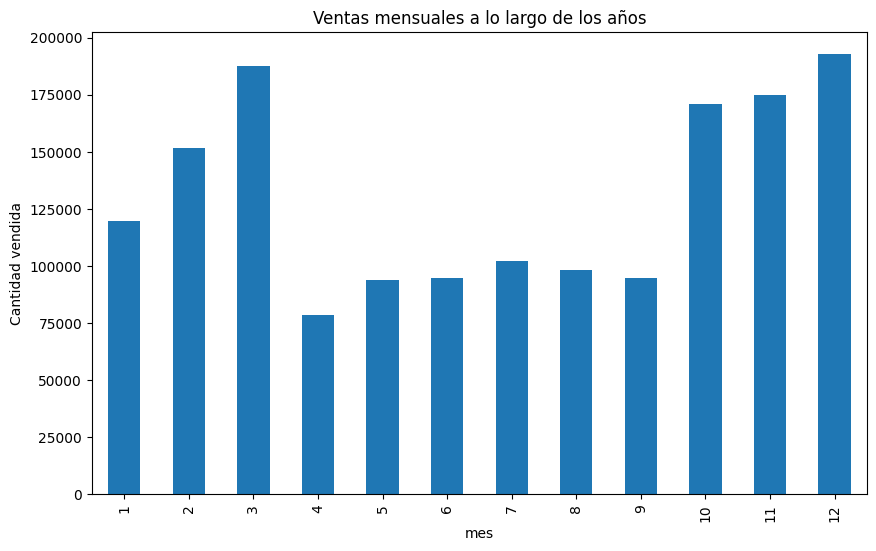

In [38]:
# Podríamos usar datos externos, con la temperatura media diaria de la localidad de cada supermercado.
# Por simplificar, mediremos las ventas por mes, comparando así con los meses más calurosos y fríos del año.

monthly_sales = sales_byday_df.resample('M', on='fecha')['cantidad'].sum()

mean_monthly_sales = sales_byday_df.groupby('mes')['cantidad'].sum()

plt.figure(figsize=(10, 6))
mean_monthly_sales.plot(kind='bar', title='Ventas mensuales a lo largo de los años', ylabel='Cantidad vendida')
plt.show()

In [ ]:
# Como podemos ver las ventas son mayores en meses de invierno, por lo que podemos concluir que la cerveza se vende más en meses fríos.